In [52]:
import json
import os
from typing import Dict, Any, List, Tuple
from scipy.spatial.distance import euclidean
import csv

def pcb_range(border: List[Dict[str, Any]]) -> Tuple[float, float, float, float]:
    if len(border) == 0:
        print("This PCB is not defined with border!")
    xs, ys = [], []
    for line in border:
        if line["type"] == "polyline":
            xs += [line["start"][0], line["end"][0]]
            ys += [line["start"][1], line["end"][1]]
        elif line["type"] == "arc":
            radius = euclidean(line["start"], line["center"])
            xs += [line["center"][0] - radius, line["center"][0] + radius]
            ys += [line["center"][1] - radius, line["center"][1] + radius]
        elif line["type"] == "circle":
            xs += [line["center"][0] - line["radius"], line["center"][0] + line["radius"]]
            ys += [line["center"][1] - line["radius"], line["center"][1] + line["radius"]]
    
    return min(xs), max(xs), min(ys), max(ys)

def load_json(pcb_file_path: str) -> Dict[str, Any]:
    with open(pcb_file_path) as jf:
        pcb_dict = json.load(jf)
    return pcb_dict

def get_pad_num(pcb_dict):
    n_pad = 0
    for net_idx in pcb_dict["nets"]:
        if int(net_idx) != -1:
            n_pad += len(pcb_dict["nets"][net_idx])
    return n_pad

data_folder = "./PCBs/" 
pcb_names = sorted(os.listdir(data_folder))
# print(len(pcb_names))

header = ['Name', 'Width', 'Height', 'Area', '#Layers', '#Nets', '#Pads', 'Net density', 'Pad density']
pad_num = []
layer_num = []
net_num = []
pcb_ranges = []
data = []
for pcb_name in pcb_names:
    raw_pcb_file = os.path.join(data_folder + pcb_name, "raw.kicad_pcb")
    json_pcb_file = os.path.join(data_folder + pcb_name, "final.json")
    if os.path.exists(json_pcb_file):
        # raw_pcb = PCB(raw_pcb_file
        pcb_dict = load_json(json_pcb_file)
        n_nets = len(pcb_dict["nets"]) if "-1" not in pcb_dict["nets"] else len(pcb_dict["nets"]) - 1
        n_pads = get_pad_num(pcb_dict)
        n_layers = len(pcb_dict["layers"])
        pcb_size = pcb_range(pcb_dict["border"])
        width = pcb_size[1] - pcb_size[0]
        height = pcb_size[3] - pcb_size[2]
        pad_num.append(n_pads)
        layer_num.append(n_layers)
        net_num.append(n_nets)
        pcb_ranges.append((pcb_size[1] - pcb_size[0], pcb_size[3] - pcb_size[2]))
        data.append([pcb_name, width, height, width * height, n_layers, n_nets, n_pads, n_nets / (width * height *  n_layers), n_pads / (width * height * n_layers)])

        # print(f"layer: {n_layers}, nets: {n_nets}, pads: {n_pads}, range: {(pcb_size[1] - pcb_size[0], pcb_size[3] - pcb_size[2])}")

with open('statistics.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    # write the data
    writer.writerow(header)
    writer.writerows(data)


In [5]:
from collections import Counter
print(len(pad_num))
print(Counter(layer_num))
print(min(pad_num), max(pad_num))
print(min(net_num), max(net_num))

139
Counter({2: 115, 4: 22, 6: 1, 8: 1})
8 1501
3 313


In [36]:
print(f"The area of your rectangle is {10}cm\u00b2")

The area of your rectangle is 10cm²


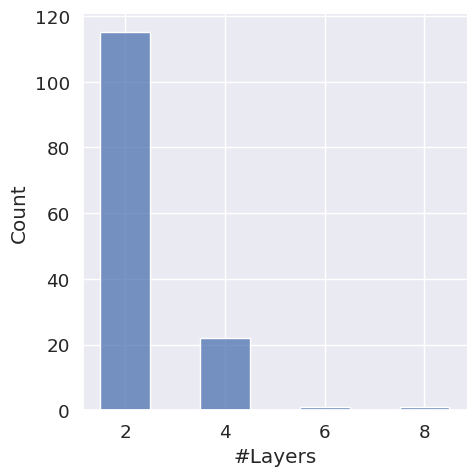

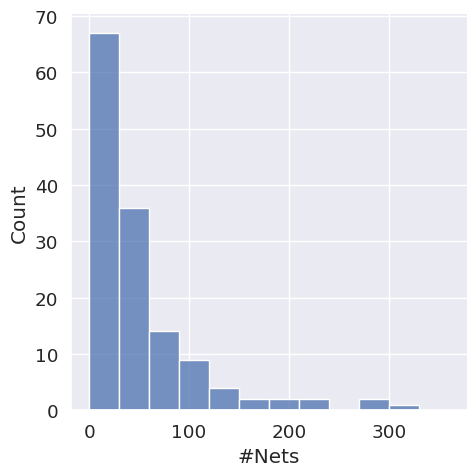

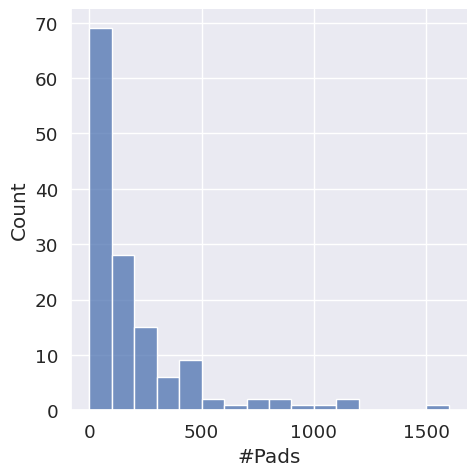

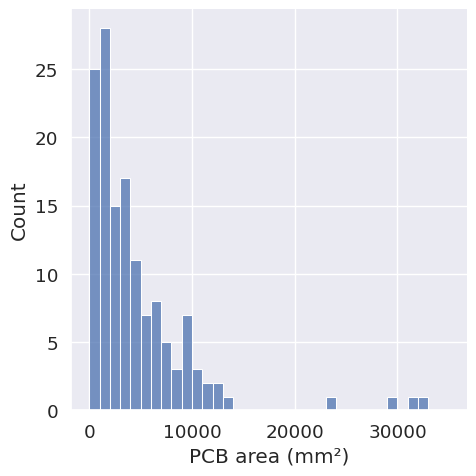

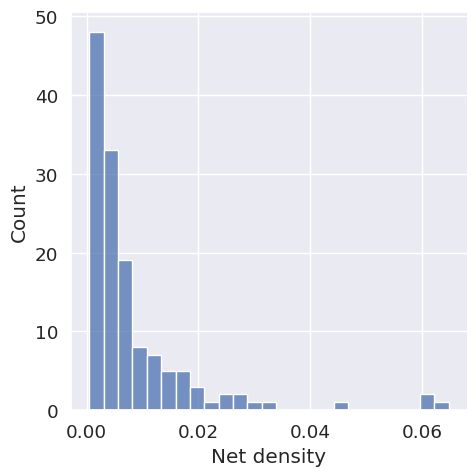

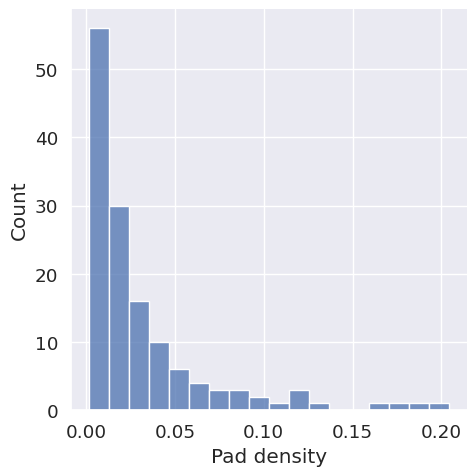

In [54]:
import seaborn as sns
import pandas as pd

sns.set(font_scale = 1.2)
data = pd.read_csv("statistics.csv")
f_layer = sns.displot(data, x="#Layers", discrete=True)
f_layer.savefig("layer_dist.pdf")

f_nets = sns.displot(data, x="#Nets", binwidth=30, binrange=(0, 350))
# f_nets.set(xlabel='Nets desity (#/mm\u00b2)')
f_nets.savefig("nets_dist.pdf")

f_pads = sns.displot(data, x="#Pads", binwidth=100, binrange=(0, 1510))
f_pads.savefig("pads_dist.pdf")

f_area = sns.displot(data, x="Area", binwidth=1000, binrange=(0, 35000))
f_area.set(xlabel='PCB area (mm\u00b2)')
f_area.savefig("area_dist.pdf")


sns.displot(data, x="Net density")
sns.displot(data, x="Pad density")